### Import Packages and Set Credentials

In [49]:
from distutils.command.bdist import show_formats
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from quantuminspire.qiskit import QI
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_histogram 

from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys

sys.path.append('../quackd')

import utils as u

u.set_qi_auth("../credentials/auth.json")

### Calibration Matrices for Spin-2 and Starmon-5 Backends

In [4]:
def create_calibration_matrix(qubits, qubit_list, backend = QI.get_backend('QX single-node simulator')):
    """
    qubits [int]: number of qubits
    qubit_list [list] = list/array of qubits indexed into the backend
    """
    # create calibration circuits
    qr = QuantumRegister(qubits)
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel="cal")
    # create calibration matrix by running calibration
    job = qiskit.execute(meas_calibs, backend=backend, shots=1024)
    cal_results = job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel="cal")
    return meas_fitter

In [6]:
start_meas_fitter_spin2 = time()

meas_fitter_spin2 = [create_calibration_matrix(2, [i], backend = QI.get_backend("Spin-2")) for i in range(2)]

finish_meas_fitter_spin2 = time()

print(f"\nElapsed Time: {np.round(finish_meas_fitter_spin2 - start_meas_fitter_spin2, 2)} seconds")


Elapsed Time: 104.32 seconds


In [5]:
start_meas_fitter_starmon = time()

meas_fitter_starmon = [create_calibration_matrix(5, [i], backend = QI.get_backend("Starmon-5")) for i in range(5)]

finish_meas_fitter_starmon = time()

print(f"\nElapsed Time: {np.round(finish_meas_fitter_starmon - start_meas_fitter_starmon, 2)} seconds")


Elapsed Time: 1639.05 seconds


In [7]:
def apply_measurement_error_mitigation(meas_fitter, raw_counts):
    """
    meas_fitter [qiskit ignis CompleteMeasFitter object]: calibration matrix fitter
    raw_counts [dict]: dictionary of bitstrings with respective counts
    """
    # apply measurement error mitigation via calibration matrix ####
    meas_filter = meas_fitter.filter
    mitigated_results = meas_filter.apply(raw_counts)
    return mitigated_results

### Build B92 Circuit

In [8]:
basis_to_bit = {"Z" : "1", "X" : "0"}

In [10]:
def build_circuit_n(
    alice_string,
    bob_bases,
    qi_backend,
    n_shots=1024,
    meas_err_mitig=False,
    meas_fitter=meas_fitter_spin2,
    n=2,
):
    if len(alice_string) != len(bob_bases):
        raise IndexError(
            "Length of bit string and length of bases to measure in do not match."
        )
    else:
        length = len(alice_string)

    circuits = []
    known_indices = []
    final_bit_string = ""

    for index in range(0, length, n):
        reg_len = n
        if length - index < n:
            reg_len = length - index

        qr = QuantumRegister(reg_len)
        circuit = QuantumCircuit(qr)
        bits = alice_string[index : index + reg_len]
        bases = bob_bases[index : index + reg_len]
        # print("bits:", bits)
        # print("bases:", bases)

        # Step 1: Initialize qubits according to Alice's bit string
        for r in range(reg_len):
            bit = bits[r]

            if bit == "0":  # if the bit is 0
                circuit.i(qr[r])  # we initialize the qubit in the |0> state
            elif bit == "1":  # if the bit is 1
                circuit.h(qr[r])  # we initialize the qubit in the |+> state

        # Step 2: Measure qubits in Bob's chosen bases
        for r in range(reg_len):
            basis = bases[r]

            if basis.upper() == "Z":  # if Bob picks the Z basis,
                circuit.i(qr[r])  # we stay in the Z basis
            elif basis.upper() == "X":  # if Bob picks the X basis,
                circuit.h(
                    qr[r]
                )  # we apply a Hadamard gate so that the measurement will be in the Z basis

        circuit.measure_all()
        circuits.append(circuit)

    # Step 3: run the circuits on the Quantum Inspire backend and compile the results
    qi_job = execute(circuits, backend=qi_backend, shots=n_shots)
    qi_result = qi_job.result()

    # Step 4: collect bits based on measurement results
    for index in range(0, length, n):
        reg_len = n
        if length - index < n:
            reg_len = length - index

        bases = bob_bases[index : index + reg_len]
        bits = alice_string[index : index + reg_len]
        circuit = circuits[index // n]
        histogram = qi_result.get_counts(circuit)
        # print(histogram)

        for r in range(reg_len):

            eigvl_cnts = {"0": 0, "1": 0}

            for key in histogram.keys():
                eigvl_cnts[key[reg_len - 1 - r]] += histogram[key]

            # print(eigvl_cnts)
            all_noisy_counts.append(eigvl_cnts)
            # apply measurement error mitigation
            if meas_err_mitig:
                eigvl_cnts = apply_measurement_error_mitigation(
                    meas_fitter[r], eigvl_cnts
                )

            # print(eigvl_cnts)
            # handle cases where mitigation removes a key
            if "0" not in eigvl_cnts.keys():
                eigvl_cnts["0"] = 0
            if "1" not in eigvl_cnts.keys():
                eigvl_cnts["1"] = 0

            all_mitigated_counts.append(eigvl_cnts)

            if eigvl_cnts["1"] >= 0.35 * n_shots:
                # state collapses to -1 eigenvalue of the measurement basis
                basis = bases[r]
                bit = basis_to_bit[basis.upper()]
                # this index with eigvl = -1 gives a determined bit that we append to known_indices
                known_indices.append(index + r)

            else:
                # state collapses to +1 eigenvalue of the measurement basis
                # or equal amount of 0 and 1 measurement results, result is indeterminate
                bit = "n"  # bit is indeterminate

            final_bit_string += bit

    return final_bit_string, known_indices, circuits

### Use B92 Circuit with Spin-2 Backend

In [53]:
all_noisy_counts = []
all_mitigated_counts = []
N_spin2 = 20

initial_bit_string_2 = np.random.choice(["0", "1"], N_spin2)
bases_2 = np.random.choice(["X", "Z"], N_spin2)

print(" ".join(initial_bit_string_2))
print(" ".join(bases_2))

start_2 = time()

final_bit_string_2, known_indices_2, circuits_2 = build_circuit_n(
    initial_bit_string_2,
    bases_2,
    QI.get_backend("Spin-2"),
    n_shots=1000,
    meas_err_mitig=True,
)

finish_2 = time()

# print(" ".join(initial_bit_string_2))
# print(" ".join(bases_2))
print(" ".join(final_bit_string_2))

print(f"\nElapsed Time: {np.round(finish_2 - start_2, 2)} seconds")

0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1
X X Z Z Z Z Z X Z X Z Z X Z Z X Z X X X
0 0 n 1 1 n 1 0 1 0 1 1 n 1 1 0 n n n n

Elapsed Time: 242.26 seconds


In [50]:
for i in range(2):
    print(meas_fitter_spin2[i].cal_matrix)

[[0.79980469 0.13183594]
 [0.20019531 0.86816406]]
[[0.90234375 0.59863281]
 [0.09765625 0.40136719]]


In [58]:
np.linalg.inv(meas_fitter_spin2[1].cal_matrix) @ [[316], [684]]

array([[-930.59807074],
       [1930.59807074]])

In [57]:
all_noisy_counts[7]

{'0': 316, '1': 684}

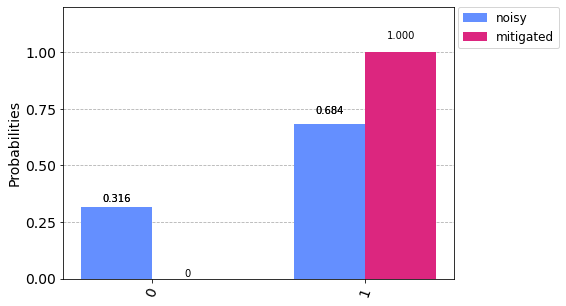

In [56]:
i = 7
plot_histogram([all_noisy_counts[i], all_mitigated_counts[i]], legend=['noisy', 'mitigated'])

We see that the measurement error mitigation is quite effective.

### Use B92 Circuit with Starmon-5 Backend

In [13]:
all_noisy_counts = []
all_mitigated_counts = []

N_starmon = 100

initial_bit_string = np.random.choice(["0", "1"], N_starmon)
bases = np.random.choice(["X", "Z"], N_starmon)

print(" ".join(initial_bit_string))
print(" ".join(bases))

start = time()

final_bit_string, known_indices, circuits = build_circuit_n(
    initial_bit_string,
    bases,
    QI.get_backend("Starmon-5"),
    n_shots=1000,
    meas_err_mitig=True,
    meas_fitter=meas_fitter_starmon,
    n=5
)

finish = time()

#print(" ".join(initial_bit_string))
#print(" ".join(bases))
print(" ".join(final_bit_string))

print(f"\nElapsed Time: {np.round(finish - start, 2)} seconds")

1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0
X X X X Z X Z Z Z X Z X Z X X X X X X Z X X Z X Z Z Z Z Z Z X X X X X Z Z Z X X Z Z Z X Z Z Z Z Z Z Z Z X Z X Z Z X Z Z X Z X X Z X X X Z Z Z X Z Z X X Z X Z X Z Z X X X Z X X X X X X X Z Z Z X Z Z Z
n 0 0 n n n 1 n n n n n n 0 n 0 0 0 0 1 n n n 0 1 n n 1 1 n n 0 n n n n n 1 n n n n 1 0 n 1 1 n n n 1 1 n n n n 1 n 1 1 0 1 n n n n 0 n 1 n 1 n n n 0 n n n n n 1 1 n n n 1 n n n 0 0 0 n n 1 n 0 n n n

Elapsed Time: 1114.22 seconds


In [15]:
for i in range(5):
    print(meas_fitter_starmon[i].cal_matrix)

[[0.94921875 0.109375  ]
 [0.05078125 0.890625  ]]
[[0.97070312 0.39746094]
 [0.02929688 0.60253906]]
[[0.96972656 0.04980469]
 [0.03027344 0.95019531]]
[[0.96289062 0.11621094]
 [0.03710938 0.88378906]]
[[0.85449219 0.10546875]
 [0.14550781 0.89453125]]


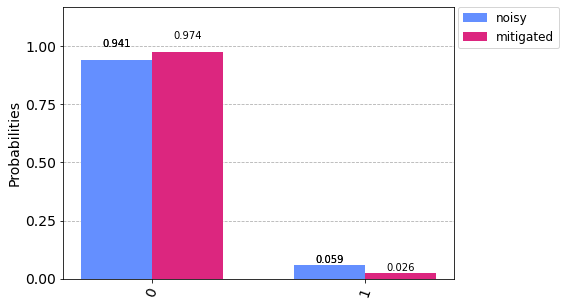

In [17]:
i = 3
plot_histogram([all_noisy_counts[i], all_mitigated_counts[i]], legend=['noisy', 'mitigated'])

We see that the measurement error mitigation is effective but not as pronounced as seen in Spin-2. This is because Starmon-5 has higher fidelities, as reflected in the 5 calibration matrices.

### Generate Alice and Bob's Keys

In [11]:
def get_secure_key_alice(alice_string, known_indices):
    secure_key = ""
    for index in known_indices:
        bit = alice_string[index]
        secure_key += bit
    return secure_key

def get_secure_key_bob(final_bit_string, known_indices):
    secure_key = ""
    for index in known_indices:
        bit = final_bit_string[index]
        secure_key += bit
    return secure_key

In [19]:
secure_key_alice = get_secure_key_alice(initial_bit_string, known_indices)
secure_key_bob = get_secure_key_bob(final_bit_string, known_indices)
print(secure_key_alice)
print(secure_key_bob)

00100000101110110111111101011011100010
00100000101110110111111101011011100010


### Perform Error Reconciliation on Bob's Key Using Cascade Protocol

In [20]:
sent_digits = list(secure_key_alice)
corrected_digits = list(secure_key_bob)

In [21]:
"""
block size k(i, Q) as a function of the iteration number i and the quantum bit error rate Q:
k(1, Q) = 0.73 / Q
k(i + 1, Q) = 2 * k(i, Q)
"""
N = len(sent_digits)
Q = np.mean(np.array(sent_digits) != np.array(corrected_digits))

In [22]:
#################### ------------ ####################
#################### BINARY SPLIT ####################
#################### ------------ ####################

# count parity
def parity(block):
    return block.count("1") % 2


# binary split and correct odd parities
def bin_split(si = 0, fi = N, parity_cnt = 1):
    if fi < N:
        block_a = sent_digits[si : fi]
        block_b = corrected_digits[si : fi]
    else:
        block_a = sent_digits[si : N - 1] + [sent_digits[N - 1]]
        block_b = corrected_digits[si : N - 1] + [corrected_digits[N - 1]]

    # print(parity_cnt)
    # print(block_a)
    # print(block_b)
    if parity(block_a) != parity(block_b):
        if fi - si == 1:
            # "0" -> "1" and "1" -> "0"
            corrected_digits[si] = str(1 - int(corrected_digits[si]))
            return parity_cnt
        else:
            # right block bigger
            mid = si + (fi - si) // 2
            return bin_split(si, mid, parity_cnt + 1) + bin_split(mid, fi, parity_cnt + 1)
    else:
        return 1


In [23]:
#################### ------- ####################
#################### SHUFFLE ####################
#################### ------- ####################
import random


def getperm(iter_n, block):
    random.seed(iter_n)
    perm = list(range(len(block)))
    random.shuffle(perm)
    random.seed()  # optional, in order to not impact other code based on random
    return perm


def shuffle(iter_n, block):
    perm = getperm(iter_n, block)
    block[:] = [block[j] for j in perm]


def unshuffle(iter_n, block):
    perm = getperm(iter_n, block)
    res = [None] * len(block)
    for i, j in enumerate(perm):
        res[j] = block[i]
    block[:] = res

In [24]:
#################### ------- ####################
#################### CASCADE ####################
#################### ------- ####################
parity_checks = [0]
block_sizes = []

# shuffle, binary split blocks, unshuffle
def cascade(iter_n):
    k = N
    if Q > 0:
        k = min(int(0.73 / Q * 2 ** iter_n), N)
    print("Block Size:", k)
    block_sizes.append(k)

    shuffle(iter_n, sent_digits)
    shuffle(iter_n, corrected_digits)

    # binary split blocks and count parity checks
    iter_n_parity_checks = 0
    for i in range(0, N, k):
        if i + k <= N:
            iter_n_parity_checks += bin_split(i, i + k)
        else:
            iter_n_parity_checks += bin_split(i, N)

    # print("Parity Checks:", iter_n_parity_checks)
    parity_checks.append(parity_checks[-1] + iter_n_parity_checks)
    # print("Cumulative Parity Checks:", parity_checks[-1])

    unshuffle(iter_n, sent_digits)
    unshuffle(iter_n, corrected_digits)

Run Cascade

In [25]:
errors = [Q]
for c in range(5):
    print()
    print("----------Testing Cascade " + str(c) + "----------")
    cascade(c)
    # print("S:", sent_digits)
    # print("C:", corrected_digits)
    error = np.mean(np.array(sent_digits) != np.array(corrected_digits))
    print("Error Rate:", error)
    print("Parity Checks:", parity_checks[-1])
    errors.append(error)

print("\n----------Final Results----------")
print("Final Block Size:", block_sizes[-1])
print("Final Error Rate:", errors[-1])
print("Final Parity Checks:", parity_checks[-1])
print("Final Parity Check Rate:", parity_checks[-1] / N)


----------Testing Cascade 0----------
Block Size: 38
Error Rate: 0.0
Parity Checks: 1

----------Testing Cascade 1----------
Block Size: 38
Error Rate: 0.0
Parity Checks: 2

----------Testing Cascade 2----------
Block Size: 38
Error Rate: 0.0
Parity Checks: 3

----------Testing Cascade 3----------
Block Size: 38
Error Rate: 0.0
Parity Checks: 4

----------Testing Cascade 4----------
Block Size: 38
Error Rate: 0.0
Parity Checks: 5

----------Final Results----------
Final Block Size: 38
Final Error Rate: 0.0
Final Parity Checks: 5
Final Parity Check Rate: 0.13157894736842105


Error Rate Plot

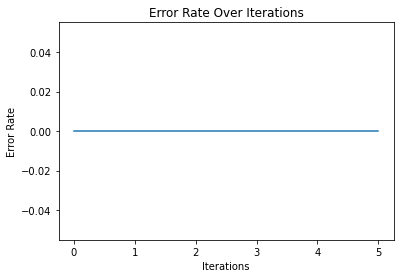

In [26]:
# Error Rate plot
plt.title("Error Rate Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Error Rate")
plt.plot(np.arange(len(errors)), errors)
plt.show()

Block Size plot

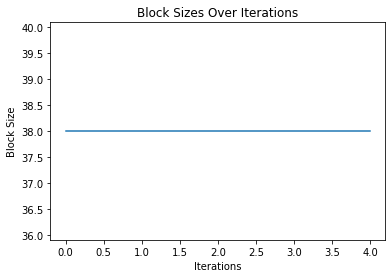

In [27]:
# Block Size plot
plt.title("Block Sizes Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Block Size")
plt.plot(np.arange(len(block_sizes)), block_sizes)
plt.show()

Parity Check plot

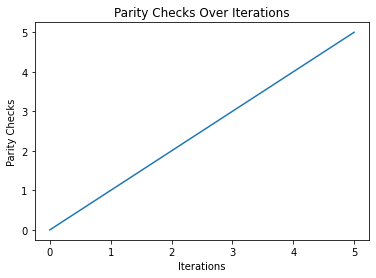

In [28]:
# Parity Check plot
plt.title("Parity Checks Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Parity Checks")
plt.plot(np.arange(len(parity_checks)), parity_checks)
plt.show()

### SHA-256 Hash for Randomness Extractor and Encryption Key

In [47]:
#################### ---- ####################
#################### HASH ####################
#################### ---- ####################

import hashlib

sent_digits_bytes = bytearray("".join(sent_digits), "utf-8")
corrected_digits_bytes = bytearray("".join(corrected_digits), "utf-8")


def hextobin(h):
    return bin(int(h, 16))[2:].zfill(len(h) * 4)


sent_hash = ""
corrected_hash = ""
# for i in range(0, N, 256):
#     if i + 256 < N:
m_sent = hashlib.sha256()
m_corrected = hashlib.sha256()

m_sent.update(sent_digits_bytes[i : i + 256])
m_corrected.update(corrected_digits_bytes[i : i + 256])

sent_hash += hextobin(m_sent.hexdigest())
corrected_hash += hextobin(m_corrected.hexdigest())

print("\n----------Hashes----------")
print("S encoding len:", len(sent_hash))
print("C encoding len:", len(corrected_hash))
print("S and C hashes match:", sent_hash == corrected_hash)
print("corrected_hash 0s:", corrected_hash.count("0"))
print("corrected_hash 1s:", corrected_hash.count("1"))
with open("out_hash.txt", "w") as hash_outfile:
    hash_outfile.write(corrected_hash)
    hash_outfile.close()

B92_KEY = corrected_hash
B92_KEY *= 309


----------Hashes----------
S encoding len: 256
C encoding len: 256
S and C hashes match: True
corrected_hash 0s: 130
corrected_hash 1s: 126


We see that SHA-256 was an effective randomness extractor, as the 0 and 1 counts are approximately the same.

### Encode and Decode Mallard Duck Image Using Bob's Corrected Encryption Key

In [39]:
from PIL import Image

IMG_FILENAME = "mallard_pixels.jpeg"
IMG_SHAPE = None

In [40]:
# ord: char to int
# chr: int to char
def ascii_to_bin(h):
    return bin(h)[2:].zfill(8)

In [41]:
def image_filename_to_ascii(filename=IMG_FILENAME):
    global IMG_SHAPE
    image = Image.open("imgs/" + filename)

    # summarize some details about the image
    print(image.format)
    print(image.size)
    print(image.mode)

    np_image = np.array(image)
    IMG_SHAPE = (image.size[1], image.size[0], 3)
    print("np_image shape:", np_image.shape)
    # print(np_image)
    plt.imshow(np_image, interpolation="nearest")
    plt.show()

    np_image_flat = np.reshape(np_image, (np.prod(np_image.shape),))
    print("np_image_flat shape:", np_image_flat.shape)
    # print(np_image_flat)
    np_image_flat_ascii = "".join([ascii_to_bin(rgb) for rgb in np_image_flat])
    # print(np_image_flat_ascii)

    return np_image_flat_ascii

In [42]:
def encrypt_image(image_ascii, key, filename=IMG_FILENAME):
    global IMG_SHAPE

    encrypted_image_ascii = int(image_ascii, 2) ^ int(key, 2)
    encrypted_image_ascii = bin(encrypted_image_ascii)[2:].zfill(
        len(image_ascii)
    )
    # print("encrypted_input_ascii len:", len(encrypted_input_ascii))
    # print(encrypted_input_ascii)

    encrypted_image = []
    for i in range(0, len(encrypted_image_ascii), 8):
        encrypted_image.append(int(encrypted_image_ascii[i : i + 8], 2))

    print("IMG_SHAPE under encrypt_image:", IMG_SHAPE)
    encrypted_image_reshaped = np.reshape(encrypted_image, IMG_SHAPE)
    print("encrypted_image_reshaped shape:", encrypted_image_reshaped.shape)
    # print("encrypted_image_reshaped:", encrypted_image_reshaped)
    plt.imshow(encrypted_image_reshaped, interpolation="nearest")
    plt.show()
    plt.imsave("imgs/encrypted_" + filename, encrypted_image_reshaped.astype("uint8"))

    return encrypted_image_ascii

In [43]:
def decrypt_image(encrypted_image, key, filename=IMG_FILENAME):
    global IMG_SHAPE

    decrypted_image_ascii = int(encrypted_image, 2) ^ int(key, 2)
    decrypted_image_ascii = bin(decrypted_image_ascii)[2:].zfill(
        len(encrypted_image)
    )

    decrypted_image = []
    for i in range(0, len(decrypted_image_ascii), 8):
        decrypted_image.append(int(decrypted_image_ascii[i : i + 8], 2))

    print("IMG_SHAPE under decrypt_image:", IMG_SHAPE)
    decrypted_image_reshaped = np.reshape(decrypted_image, IMG_SHAPE)
    print("decrypted_image_reshaped shape:", decrypted_image_reshaped.shape)
    # print("decrypted_image_reshaped:", decrypted_image_reshaped)
    plt.imshow(decrypted_image_reshaped, interpolation="nearest")
    plt.show()
    plt.imsave("imgs/decrypted_" + filename, decrypted_image_reshaped.astype("uint8"))

    return decrypted_image_reshaped

Display Encrypted and Decrypted Mallard Duck Image

JPEG
(66, 50)
RGB
np_image shape: (50, 66, 3)


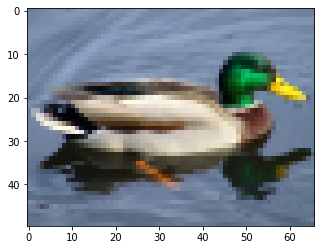

np_image_flat shape: (9900,)
IMG_SHAPE under encrypt_image: (50, 66, 3)
encrypted_image_reshaped shape: (50, 66, 3)


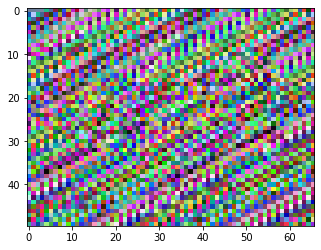

IMG_SHAPE under decrypt_image: (50, 66, 3)
decrypted_image_reshaped shape: (50, 66, 3)


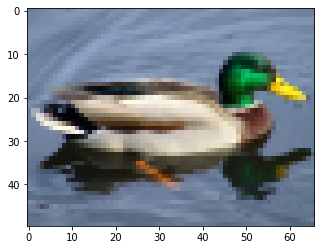

In [48]:
img_ascii = image_filename_to_ascii(IMG_FILENAME)
encrypted_img = encrypt_image(img_ascii, B92_KEY)
decrypted_img = decrypt_image(encrypted_img, B92_KEY)

The encrypted mallard duck image is indecipherable, also attesting to the efficacy of our encryption key.